In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **1. Цель работы**

Разработка автоматизированного решения для распознования номеров припаркованных автомобилей.


# **2. Загрузка изображений**

In [276]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import re

Изображения загружается из целевой папки по названию carX.jpg

In [322]:
# Определение списка фотографий автомобилей в целевой папке
folder_path = '/content/drive/MyDrive/CV/Project/'
# Создаем пустой список для сохранения названий изображений автомобилей
car_files = []

# Перебираем все файлы в папке
for filename in os.listdir(folder_path):
    # Проверяем, соответствует ли имя файла шаблону carX.jpg
    if filename.startswith('car') and filename.endswith('.jpg'):
        # Проверяем, что между 'car' и '.jpg' есть число
        middle_part = filename[3:-4]
        if middle_part.isdigit():
            car_files.append(filename)

In [324]:
# Сохранение прочитанных изображений в список
car_images_colored = []

for car_img in car_files:
  img = cv2.imread(folder_path + car_img)
  img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  car_images_colored.append(img)

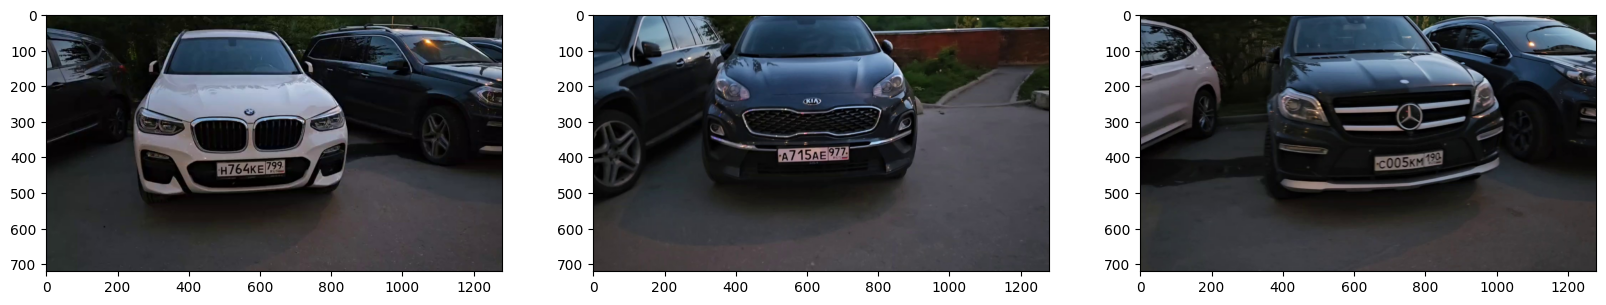

In [325]:
# Вывод на экран изображений из списка car_images_colored
f, axes = plt.subplots(1,3, figsize=(20, 10))
axes[0].imshow(car_images_colored[0][...,::-1])
axes[1].imshow(car_images_colored[1][...,::-1])
axes[2].imshow(car_images_colored[2][...,::-1])
plt.show()

# **3. Аугментация для создания реалистичных искажений**

In [326]:
# Подключение необходимых библиотек
import cv2 as cv
import skimage

In [354]:
# Написание функций преобразования изображения

# Изменение оттенка изображения
def change_hue(img, delta):
    new_img = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    img_h = new_img[:, :, 0]
    img_new_h = (img_h + delta) % 180
    new_img[:, :, 0] = img_new_h
    new_img = cv.cvtColor(new_img, cv.COLOR_HSV2BGR)
    return new_img

# Изменение насыщенности
def change_saturation(img, factor):
    new_img = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    img_s = new_img[:, :, 1].astype('float32')
    img_new_s = np.clip(img_s * factor, 0, 255)
    new_img[:, :, 1] = img_new_s.astype('uint8')
    new_img = cv.cvtColor(new_img, cv.COLOR_HSV2BGR)
    return new_img

# Изменение яркости
def change_brightness(img, delta):
    new_img = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    img_v = new_img[:, :, 2].astype('int16')
    img_new_v = np.clip(img_v + delta, 0, 255).astype('uint8')
    new_img[:, :, 2] = img_new_v
    new_img = cv.cvtColor(new_img, cv.COLOR_HSV2BGR)
    return new_img


# изменение контрастности
def change_contrast(img, factor):
    new_img = np.clip(127.5 + factor * (img - 127.5), 0, 255).astype("uint8")
    return new_img

# изменение гаммы
def change_gamma(img, gamma):
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in
                      np.arange(0, 256)]).astype("uint8")
    new_img = cv.LUT(img, table)
    return new_img

# приближение
def zoom_in(img, factor):
    img_height, img_width = img.shape[:2]
    M = cv.getRotationMatrix2D(center=(img_width / 2, img_height / 2),
                               angle=0,
                               scale=factor)
    new_img = cv.warpAffine(img, M=M, dsize=(img_width, img_height))
    return new_img

def zoom_out(img, factor): # отдаление
    img_height, img_width = img.shape[:2]
    M = cv.getRotationMatrix2D(center=(img_width / 2, img_height / 2),
                               angle=0,
                               scale=factor)
    new_img = cv.warpAffine(img,
                            M=M,
                            dsize=(img_width, img_height))
    return new_img

def rotate(img, angle): # поворот
    img_height, img_width = img.shape[:2]
    M = cv.getRotationMatrix2D(center=(img_width / 2, img_height / 2),
                               angle=angle,
                               scale=1)
    new_img = cv.warpAffine(img,
                            M=M,
                            dsize=(img_width, img_height)
                            )
    return new_img


In [329]:
# Классы-обертки функций

class RandomChangeColor:
    '''
    Случайное изменение цвета изображения.
    '''
    def __init__(self,
                 hue_delta_range=(0, 10),
                 saturation_factor_range=(0.5, 1.5),
                 brightness_delta_range=(0, 90),
                 contrast_factor_range=(0.5, 2),
                 gamma_range=(0.5, 2),
                 prob=0.5):
        self.prob = 0.5
        self.hue_delta_range_min = hue_delta_range[0]
        self.hue_delta_range_max = hue_delta_range[1]
        self.saturation_factor_range_min = saturation_factor_range[0]
        self.saturation_factor_range_max = saturation_factor_range[1]
        self.brightness_delta_range_min = brightness_delta_range[0]
        self.brightness_delta_range_max = brightness_delta_range[1]
        self.contrast_factor_range_min = contrast_factor_range[0]
        self.contrast_factor_range_max = contrast_factor_range[1]
        self.gamma_range_min = gamma_range[0]
        self.gamma_range_max = gamma_range[1]
        '''
        Arguments:
            prob (float, optional): вероятность срабатывания преобразования
            hue_delta_range (tuple, optional) - диапазон выбора значений для изменения оттенка
            saturation_factor_range (tuple, optional) - диапазон выбора значений для измненеия насыщенности
            brightness_delta_range (tuple, optional) - диапазон выбора значений для измненеия яркости
            contrast_factor_range (tuple, optional) - диапазон выбора значений для измненеия контраста
            gamma_range (tuple, optional) - диапазон выбора значений для гаммы

        '''

    def __call__(self, img):
        p = np.random.uniform(0,1) # выбор вероятности срабатывания
        if p >= self.prob:
            hue_delta = np.random.uniform(self.hue_delta_range_min,
                                          self.hue_delta_range_max) # выбор фактора
            img = change_hue(img, hue_delta)
            return img
        p = np.random.uniform(0,1)
        if p >= self.prob:
            saturation_factor = np.random.uniform(self.saturation_factor_range_min,
                                                  self.saturation_factor_range_max) # выбор фактора
            img = change_saturation(img, saturation_factor)
            return img
        p = np.random.uniform(0,1)
        if p >= self.prob:
          # выбор фактора
            brightness_delta = np.random.uniform(self.brightness_delta_range_min,
                                                 self.brightness_delta_range_max)
            img = change_brightness(img, brightness_delta)
            return img
        p = np.random.uniform(0,1)
        if p >= self.prob:
            contrast_factor = np.random.uniform(self.contrast_factor_range_min,
                                                self.contrast_factor_range_max) # выбор фактора
            img = change_contrast(img, contrast_factor)
            return img
        p = np.random.uniform(0,1)
        if p >= self.prob:
            gamma = np.random.uniform(self.gamma_range_min,
                                      self.gamma_range_max) # выбор фактора
            return change_gamma(img, gamma)
        else:
            return img

class RandomZoomIn:
    '''
    Случайное приближение изображения.
    '''
    def __init__(self, factor_range=(1.1,1.3), prob=0.5):
        '''
        Arguments:
            factor_range (tuple, optional): диапазон выбора фактора приближения
            prob (float, optional): вероятность срабатывания преобразования
        '''
        self.min_factor = factor_range[0]
        self.max_factor = factor_range[1]
        self.prob = prob

    def __call__(self, img):
        p = np.random.uniform(0,1) # выбор вероятности срабатывания
        if p >= self.prob:
            factor = np.random.uniform(self.min_factor, self.max_factor) # выбор фактора
            return zoom_in(img, factor)
        else:
            return img

class RandomZoomOut:
    '''
    Случайное отдаление изображения.
    '''
    def __init__(self, factor_range=(0.8,1), prob=0.5):
        '''
        Arguments:
            factor_range (tuple, optional): диапазон выбора фактора приближения
            prob (float, optional): вероятность срабатывания преобразования
        '''
        self.min_factor = factor_range[0]
        self.max_factor = factor_range[1]
        self.prob = prob

    def __call__(self, img):
        p = np.random.uniform(0,1) # выбор вероятности срабатывания
        if p >= self.prob:
            factor = np.random.uniform(self.min_factor, self.max_factor) # выбор фактора
            return zoom_out(img, factor)
        else:
            return img

class RandomNoise:
    '''
    Случайное наложение шума.
    '''
    def __init__(self, prob=0.5):
        '''
        Arguments:
            prob (float, optional): вероятность срабатывания преобразования
        '''
        self.prob = prob

    def __call__(self, img):
        p = np.random.uniform(0,1) # выбор вероятности срабатывания
        if p >= self.prob:
            img = skimage.util.random_noise(img, mode='s&p')
            img_noise_sp = (255 * img).astype(np.uint8)

            new_img = skimage.util.random_noise(img_noise_sp, mode='gaussian')
            img_noise_gaussian = (255 * new_img).astype(np.uint8)
            return img_noise_gaussian
        else:
            return img

In [338]:
# Применение аугментации
augmentation_steps = [RandomChangeColor(), RandomNoise(),
                      RandomZoomOut(), RandomZoomIn()]


In [468]:
%%time

#Применяем все аугментации последовательно к одному изображению
def apply_augmentations(images, augmentation_steps):
    imges_augmentation = []
    for img in images:
      if img is None:
        continue
      for transform in augmentation_steps:
        img = transform(img)
      imges_augmentation.append(img)
    return imges_augmentation

images_aug = apply_augmentations(car_images_colored, augmentation_steps)

CPU times: user 238 ms, sys: 41.6 ms, total: 279 ms
Wall time: 249 ms


Вывод исходных и аугментированных изображений

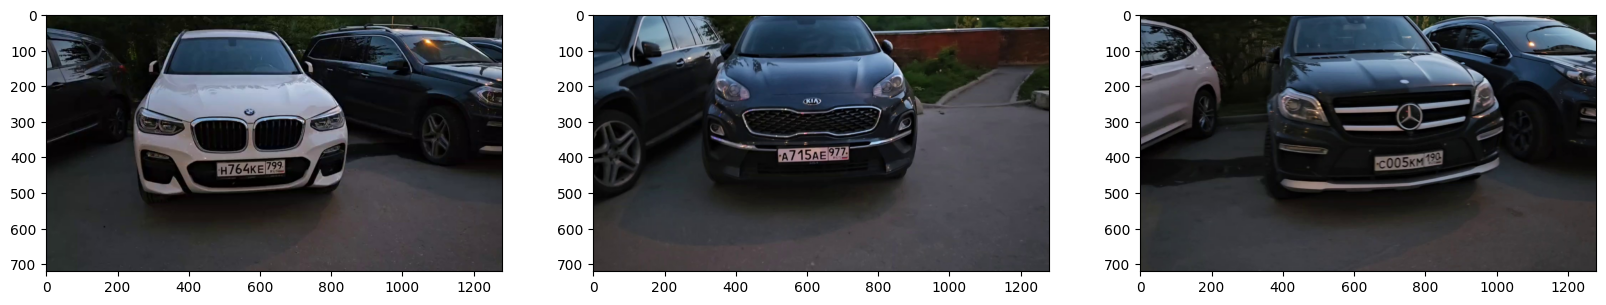

In [469]:
# Вывод исходных изображений
f, axes = plt.subplots(1,3, figsize=(20, 10))
axes[0].imshow(car_images_colored[0][...,::-1])
axes[1].imshow(car_images_colored[1][...,::-1])
axes[2].imshow(car_images_colored[2][...,::-1])
plt.show()

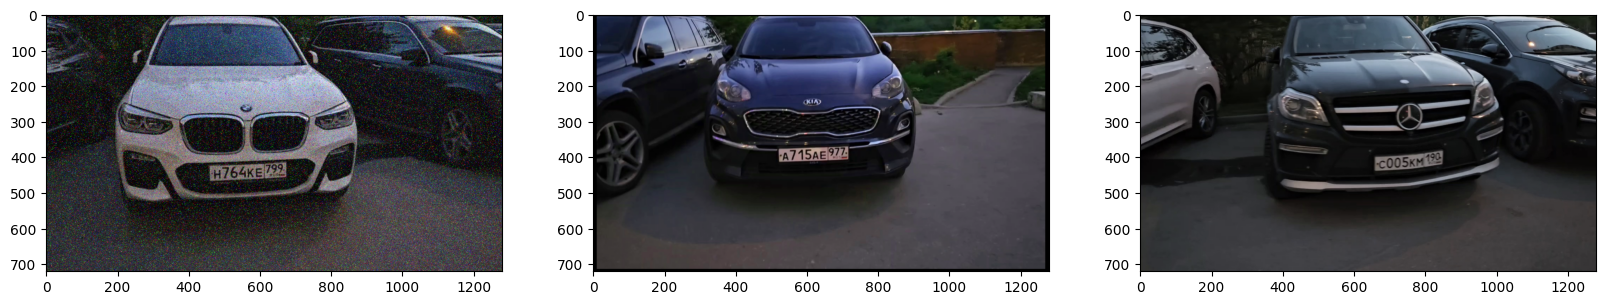

In [470]:
# Вывод исходных аугментированных изображений
f, axes = plt.subplots(1,3, figsize=(20, 10))
axes[0].imshow(images_aug[0][...,::-1])
axes[1].imshow(images_aug[1][...,::-1])
axes[2].imshow(images_aug[2][...,::-1])
plt.show()

# **4. Предобработка изображений**



In [511]:
# импорт необходимых библиотек
from skimage.filters import median
from skimage.morphology import square

In [512]:
# Функция для заливки контуров белым цветом
def fill_contours(binary_image):
  contours, hierarchy = cv2.findContours(
    binary_image,
    cv2.RETR_EXTERNAL ,  # Иерархическая структура (внешние и внутренние контуры)
    cv2.CHAIN_APPROX_SIMPLE
  )

  # Создаем маску для заливки
  filled_mask = np.zeros_like(binary_image)
# Заливаем контуры белым цветом (255)
  cv2.drawContours(
    filled_mask,
    contours,
    contourIdx=-1,  # Все контуры
    color=255,      # Белый цвет
    thickness=cv2.FILLED  # Заливка внутренней части
  )
  return filled_mask

In [513]:
# Функция по предобработке изображений
def preprocess_car_image(images_aug):
  images_preprocessed = []
  for img in images_aug:
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = median(img_gray, square(5))
    edges = cv2.Canny(blur, 50, 150, apertureSize=3, L2gradient = True)
    threshold, binary_img = cv2.threshold(edges, 120, 255,
                                          cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Морфологические операции, не забудьте применить прямоугольный фильтр!
    kernel = np.ones((1, 52), dtype='uint8')
    binary_img_clean = cv2.morphologyEx(binary_img, cv2.MORPH_CLOSE,
                                        kernel, iterations=1)

    # kernel = np.ones((1, 38), dtype='uint8')
    # binary_img_clean = cv2.morphologyEx(binary_img_clean, cv2.MORPH_CLOSE,
    #                                     kernel, iterations=2)

    kernel = np.ones((2, 3), dtype='uint8')
    binary_img_clean = cv2.morphologyEx(binary_img_clean, cv2.MORPH_CLOSE,
                                        kernel, iterations=2)

    # kernel = np.ones((3, 3), dtype='uint8')
    # erode = cv2.dilate(binary_img_clean, kernel, iterations=3)

    kernel = np.ones((3, 1), dtype='uint8')
    erode = cv2.erode(binary_img_clean, kernel, iterations=6)

    binary_img_clean = fill_contours(erode)

    images_preprocessed.append(binary_img_clean)

  return images_preprocessed

In [471]:
# Сохраняю предобработанные изображения в список
images_preprocessed = preprocess_car_image(images_aug)

<ipython-input-288-2251327a8248>:8: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  blur = median(img_gray, square(5))


In [514]:
# Вывод входных и предобработанных изображений
f, axes = plt.subplots(2,3, figsize=(40, 20))
axes[0, 0].imshow(images_aug[0][..., :: -1])
axes[0, 1].imshow(images_aug[1][..., :: -1])
axes[0, 2].imshow(images_aug[2][..., :: -1])
axes[1,0].imshow(images_preprocessed[0], cmap='gray')
axes[1,1].imshow(images_preprocessed[1], cmap='gray')
axes[1,2].imshow(images_preprocessed[2], cmap='gray')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

# **5. Поиск области с текстом**

In [515]:
# Функция по поиску самого белого участка из детектирвоанных
def select_whitest_image(image_list):
    """
    Выбирает самое белое изображение из списка на основе средней яркости.

    Параметры:
        image_list: список изображений в формате numpy.ndarray (BGR или Grayscale)

    Возвращает:
        tuple: (самое белое изображение, его индекс в списке, средняя яркость)
        или (None) если список пуст
    """
    if not image_list:
        return None

    max_brightness = -1
    whitest_image = None
    whitest_index = -1

    for i, img in enumerate(image_list):
        # Конвертируем в grayscale если нужно
        if len(img.shape) == 3:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        else:
            gray = img

        # Вычисляем среднюю яркость
        brightness = np.mean(gray)

        # Обновляем самое белое изображение
        if brightness > max_brightness:
            max_brightness = brightness
            whitest_image = img

    return whitest_image

In [516]:
def get_plate(preprocessed_img, orig_img, min_aspect_ratio=5.0, max_aspect_ratio=11.0,
              min_area=1000, max_area=30000, angle_threshold=15, min_white_ratio=0.3):
    """
    Находит и вырезает область с автомобильным номером на бинарном изображении.

    Параметры:
        preprocessed_img (numpy.ndarray): бинарное изображение (0 - фон, 255 - объекты)
        orig_img (numpy.ndarray): оригинальное изображение (для вырезки)
        min_aspect_ratio (float): минимальное соотношение сторон (ширина/высота)
        max_aspect_ratio (float): максимальное соотношение сторон
        min_area (int): минимальная площадь контура
        max_area (int): максимальная площадь контура
        angle_threshold (int): допустимый угол наклона (± градусов)

    Возвращает:
        list: список изображений с найденными номерами (или пустой список)
    """
    plates = []
    # Находим контуры
    contours, _ = cv2.findContours(preprocessed_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for cnt in contours:
        # Получаем минимальный ограничивающий прямоугольник
        rect = cv2.minAreaRect(cnt)
        box = cv2.boxPoints(rect)
        box = np.int32(box)

        # Вычисляем ширину, высоту и угол
        (x, y), (w, h), angle = rect

        # Корректируем угол, чтобы он был в диапазоне [-45, 45]
        if w < h:
            w, h = h, w  # меняем местами, чтобы width всегда был больше height
            angle -= 90  # корректируем угол

        # Нормализуем угол в диапазон [-angle_threshold, angle_threshold]
        angle = abs(angle)  # нас интересует абсолютное значение

        # Рассчитываем соотношение сторон и площадь
        aspect_ratio = w / max(h, 0.1)
        area = w * h

        # Фильтрация по всем параметрам
        if (min_aspect_ratio <= aspect_ratio <= max_aspect_ratio and
            min_area <= area <= max_area and angle < angle_threshold):
            # Вырезаем номер с помощью perspective transform
            plate = four_point_transform(orig_img, box)
            plates.append(plate)

    plate_best = select_whitest_image(plates)

    return plate_best

def four_point_transform(image, pts, margin=5):
    """
    Вырезает и выравнивает область по 4 точкам с добавлением margin.

    Параметры:
        image: исходное изображение
        pts: 4 точки ограничивающего прямоугольника
        margin: отступ в пикселях (по умолчанию 10)
    """
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    # Вычисляем ширину и высоту новой картинки
    widthA = np.linalg.norm(br - bl)
    widthB = np.linalg.norm(tr - tl)
    maxWidth = max(int(widthA), int(widthB)) + 2 * margin  # добавляем margin

    heightA = np.linalg.norm(tr - br)
    heightB = np.linalg.norm(tl - bl)
    maxHeight = max(int(heightA), int(heightB)) + 2 * margin  # добавляем margin

    # Формируем матрицу преобразования
    dst = np.array([
        [margin, margin],  # сдвигаем точку назначения на margin
        [maxWidth - 1 - margin, margin],
        [maxWidth - 1 - margin, maxHeight - 1 - margin],
        [margin, maxHeight - 1 - margin]], dtype="float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    return warped

def order_points(pts):
    """
    Упорядочивает точки в порядке: верх-лево, верх-право, низ-право, низ-лево.
    """
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]  # верх-лево (min сумма)
    rect[2] = pts[np.argmax(s)]  # низ-право (max сумма)

    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]  # верх-право (min разность)
    rect[3] = pts[np.argmax(diff)]  # низ-лево (max разность)
    return rect

In [519]:
# Сохраняю найденные изобрадения с текстом в список
plates = []
# Передаю функции get_plate обработанные и исходные изображения
for preprocessed_img, orig_img in zip(images_preprocessed, images_aug):
  plate = get_plate(preprocessed_img, orig_img)
  if plate is not None:
    plates.append(plate)

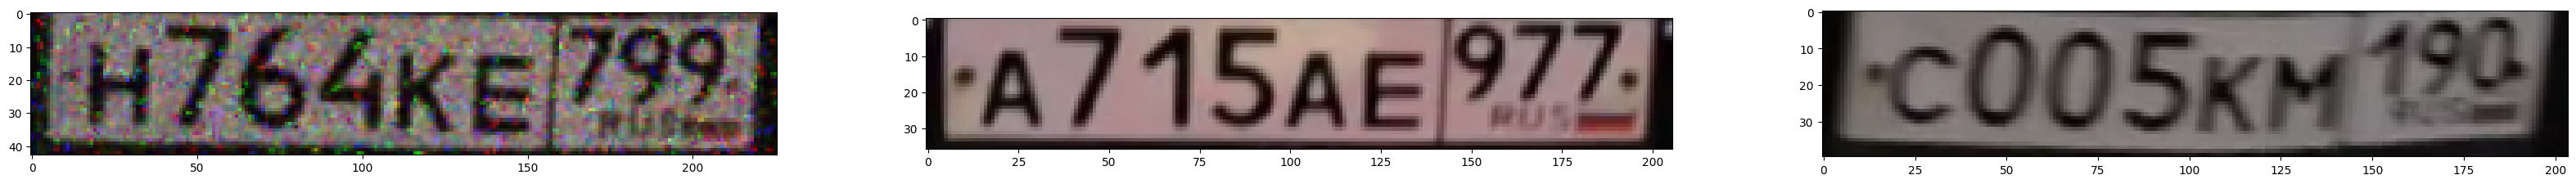

In [520]:
# Вывод изображений с текстом
f, axes = plt.subplots(1,3, figsize=(40, 20))
axes[0].imshow(plates[0][..., :: -1])
axes[1].imshow(plates[1][..., :: -1])
axes[2].imshow(plates[2][..., :: -1])
plt.show()

# **6. Предобработка области с текстом**

In [522]:
def preprocessed_plate(plate, kernel_size=1, apply_denoise=False):
  """
    Предобработка изображения номерного знака для улучшения распознавания текста.

    Параметры:
        plate: изображение номера (BGR или Grayscale)
        border_size: размер черной рамки вокруг номера (пиксели)
        kernel_size: размер ядра для морфологических операций
        apply_denoise: флаг применения подавления шумов

    Возвращает:
        Обработанное бинарное изображение номера
    """
    # 1. Конвертация в grayscale
  if len(plate.shape) == 3:
      gray = cv2.cvtColor(plate, cv2.COLOR_BGR2GRAY)
  else:
      gray = plate.copy()

  # gray = cv2.equalizeHist(gray)

    # 2. Добавление черной рамки (убирает артефакты по краям)
  # bordered = cv2.copyMakeBorder(gray,
  #                               border_size, border_size,
  #                               border_size, border_size,
  #                               cv2.BORDER_CONSTANT,
  #                               value=0)

    # 3. Адаптивная бинаризация 21 3
  binary = cv2.adaptiveThreshold(gray,
                                255,
                                cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                cv2.THRESH_BINARY,
                                21,
                                3)


    # 4. Морфологические операции
  kernel = np.ones((kernel_size, kernel_size), np.uint8)
  processed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=3)
  processed = cv2.morphologyEx(processed, cv2.MORPH_OPEN, kernel, iterations=5)

  kernel = np.ones((1, 2), dtype='uint8')
  processed = cv2.dilate(processed, kernel, iterations=1)

    # 5. Подавление шумов (опционально)
  if apply_denoise:
        processed = cv2.medianBlur(processed, 3)

    # 6. Удаление рамки перед возвратом результата
  # h, w = processed.shape
  # result = processed[border_size:h-border_size, border_size:w-border_size]

  return processed

In [535]:
# Адаптивный медианный фильтр для исключение шума

def adaptive_median_filter(image_array, window_size=1, threshold=0.0):
    """
    Применяет адаптивный медианный фильтр к изображению.

    Параметры:
    image_array - numpy array изображения (2D массив)
    window_size - размер окна фильтра (1 = 3x3, 2 = 5x5 и т.д.)
    threshold - порог адаптивности (0 = обычный медианный фильтр)

    Возвращает:
    Обработанное изображение (numpy array)
    """
    # Определяем размеры изображения и фильтра
    ylength, xlength = image_array.shape
    filter_window_size = 2 * window_size + 1
    vlength = filter_window_size * filter_window_size

    # Создаем копию изображения для обработки
    output_array = np.copy(image_array)
    pixel_count = 0

    # Основной цикл обработки
    for y in range(window_size, ylength - window_size):
        for x in range(window_size, xlength - window_size):
            # Получаем текущее окно
            window = image_array[y-window_size:y+window_size+1,
                                x-window_size:x+window_size+1]
            window_flat = window.flatten()

            # Вычисляем медиану
            median = np.median(window_flat)

            # Применяем адаптивный порог
            if threshold > 0:
                scale = np.abs(window_flat - median)
                scale_sorted = np.sort(scale)
                Sk = 1.4826 * scale_sorted[len(scale_sorted)//2]
                if abs(image_array[y, x] - median) > (threshold * Sk):
                    output_array[y, x] = median
                    pixel_count += 1
            else:
                output_array[y, x] = median
                pixel_count += 1

    return output_array

In [541]:
def get_clean_plate(plate, border_size=0, apply_denoise=False):

    gray = cv2.cvtColor(plate, cv2.COLOR_BGR2GRAY)
    plate_filtered = adaptive_median_filter(gray)
    plate_preprocessed = preprocessed_plate(plate_filtered)

    # Поиск контуров
    contours, hierarchy = cv2.findContours(plate_preprocessed, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # img_with_contours = cv2.drawContours(plate_colored.copy(), contours, -1, (0,255,0), 1)

    # Фильтр по площади
    contours = [cnt for cnt in contours if 2000 > cv2.contourArea(cnt) > 100]

    plate_rect = [] # переменная для координат бокса с номерным знаком
    img_rects = plate.copy()

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt) # получить прямоугольник из контура
        if 2.5 > (h/w) > 0.7: # финальный фильтр по соотношению сторон
            img_rects = cv2.rectangle(img_rects, (x, y), (x+w, y+h), (0, 0, 255), 1) # отрисовать буквы красным
            plate_rect.append([x, y, x+w, y+h]) # запоминаем координаты прямугольников вокруг букв

    # Если найдены прямоугольники
    if plate_rect:
        # # Находим общий bounding box для всех прямоугольников
        # x_min = min([rect[0] for rect in plate_rect])
        # y_min = min([rect[1] for rect in plate_rect])
        # x_max = max([rect[2] for rect in plate_rect])
        # y_max = max([rect[3] for rect in plate_rect])

        # # Добавляем margin (5 пикселей)
        # margin = 2
        # x_min = max(0, x_min - margin)
        # y_min = max(0, y_min - margin)
        # x_max = min(plate_preprocessed.shape[1], x_max + margin)
        # y_max = min(plate_preprocessed.shape[0], y_max + margin)


        # Вырезаем область номерного знака
        # plate_region = plate_preprocessed[y_min:y_max, x_min:x_max]
        # plate_region_resized = resize(plate_region, (320, 320))

        plate_region = np.ones(plate_preprocessed.shape, dtype=np.uint8) * 255

        for rect in plate_rect:
          plate_region[rect[1]:rect[3], rect[0]:rect[2]] = plate_preprocessed[rect[1]:rect[3], rect[0]:rect[2]]

        return plate_region



In [538]:
# Сохраняю предобработанные области с текстом в список
clean_plate = []
for plate in plates:
  clean_plate.append(get_clean_plate(plate))

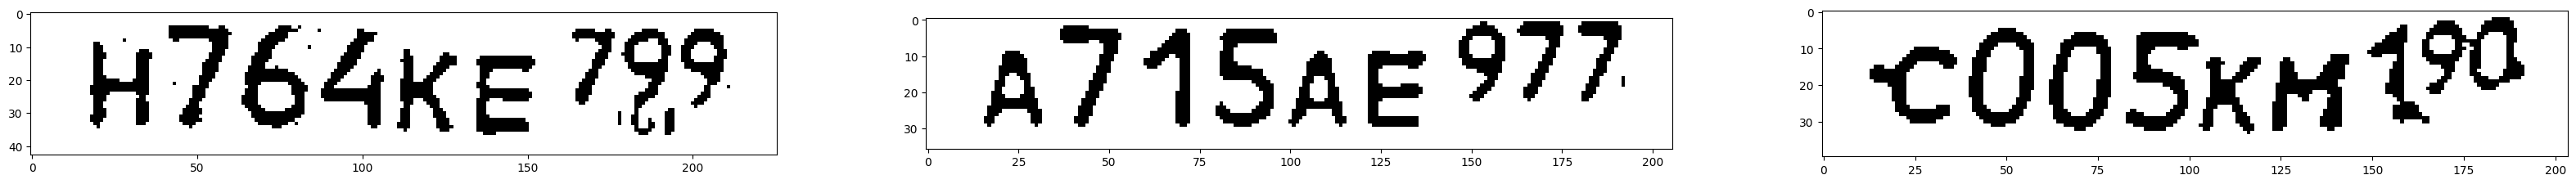

In [542]:
# вывод предобработанных изображений
f, axes = plt.subplots(1,3, figsize=(40, 20))
axes[0].imshow(clean_plate[0], cmap='gray')
axes[1].imshow(clean_plate[1], cmap='gray')
axes[2].imshow(clean_plate[2], cmap='gray')
plt.show()

# **7. Распознавание текста**

In [543]:
# Установка зависимостей (Tesseract + EasyOCR для сравнения)
!sudo apt install tesseract-ocr
!pip install pytesseract opencv-python easyocr numpy

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [549]:
# Импорт необходимых библиотек
import pytesseract
import re

In [550]:
# Инициализация Tesseract (в Colab он уже в PATH)
pytesseract.pytesseract.tesseract_cmd = '/usr/bin/tesseract'

In [552]:
def recognize_plate_text(img):

    # Распознавание через Tesseract
    custom_config = r'--oem 3 --psm 7 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
    text = pytesseract.image_to_string(img, config=custom_config)
    cleaned_text = re.sub(r'[^A-Z0-9]', '', text)
    return cleaned_text

In [555]:
# Распознанный текст сохраняю в список text_numbers
text_numbers = []
for plate in clean_plate:
  text_numbers.append(recognize_plate_text(plate))

In [557]:
# Вывод распознанного текста
text_numbers

['H764KE799', 'A715AE977', 'CO05KM190']

# **8. Коррекция текста**

In [559]:
# Функция по коррекции текста
def get_number(raw_text):

    raw_text_list = list(raw_text)

    # Заменяю буквы, похожие на цифры
    for i, letter in enumerate(raw_text_list[1:4]):
      if letter == 'O':
        raw_text_list[i+1] = '0'
      if letter == 'S':
        raw_text_list[i+1] = '5'
      if letter == 'J':
        raw_text_list[i+1] = '7'

    raw_text = ''

    for letter in raw_text_list:
      raw_text += letter

    # Оставляем только буквы (кириллица) и цифры
    cleaned = re.sub(r'[^A-Za-z0-9]', '', raw_text.upper())

    # Проверяем длину (минимум 6 символов: 1 буква + 3 цифры + 2 буквы)
    if len(cleaned) < 6:
        return None

    # Разделяем на серию и регион (первые 6 символов — серия, остальное — регион)
    series = cleaned[:6]
    region = cleaned[6:] if len(cleaned) > 6 else "000"  # Если региона нет, ставим 000

    # Проверяем, что серия соответствует формату "БЦЦЦББ"
    if not re.match(r'^[A-Z]\d{3}[A-Z]{2}$', series):
        return None

    # Проверяем, что регион состоит из цифр (1–3 цифры)
    if not re.match(r'^\d{1,3}$', region):
        return None

    # Форматируем регион (дополняем нулями до 3 цифр)
    region_padded = region.zfill(3)

    # Возвращаем номер в формате "БЦЦЦББ РРР"
    return f"{series} {region_padded}"

In [560]:
# Скорректированный текст сохраняю в список numbers. Номера представлены
# в формате: «БЦЦЦББ РРР»
numbers = []
for number in text_numbers:
  numbers.append(get_number(number))

In [562]:
# Вывод номеров в формате: «БЦЦЦББ РРР»
numbers

['H764KE 799', 'A715AE 977', 'C005KM 190']

# **9. Оценка качества распознавания**

In [563]:
# Импорт необходимых библиотек
import nltk

In [564]:
# Список корректных номеров в формате «БЦЦЦББ РРР»
true_numbers = ['H764KE 799', 'A715AE 977', 'C005KM 190']

In [568]:
# Определение метрики CER для полученного и ожидаемого результатов.
cer = []
for true, number in zip(true_numbers, numbers):
  levenshtein_distance = nltk.edit_distance(true, number)
  cer.append(levenshtein_distance/len(true))

In [566]:
# Вывод метрики CER для полученного и ожидаемого результатов.
cer

[0.0, 0.0, 0.0]

# **Выводы**

В ходе выполнения работы была реализована система обработки и распознавания автомобильных номеров на изображениях. Основные этапы включали загрузку данных, аугментацию, предобработку, поиск областей с текстом, обработку номеров, распознавание символов и коррекцию результата.

Согласно метрике CER система распознования вавтомобильных номеров работает удовлетворительно.

В целом, система успешно справляется с поставленной задачей, но требует доработок для повышения точности в сложных сценариях.


